**временные ряды, модели регрессии, извлечение признаков**

Евгений Борисов <esborisov@sevsu.ru>

-----

Дмитрий Макаров   Временные ряды.    
https://www.dmitrymakarov.ru/intro/time-series-20/

Евгений Рябенко Прогнозирование временных рядов.     
https://www.youtube.com/watch?v=u433nrxdf5k



How To Create Time Series Features with tsfresh    
https://www.rasgoml.com/feature-engineering-tutorials/how-to-create-time-series-features-with-tsfresh`

-----

#  загружаем данные

In [1]:
import numpy as np
from numpy import random as rng
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Data from Google Finance

from pandas_datareader.data import DataReader
# df = DataReader("AAPL", "stooq")
# df = DataReader("GS", "stooq") 
df = DataReader("IBM", 'stooq').reset_index()
df = df[['Date','Close']].rename(columns={'Close':'values','Date':'date'})
df = df.set_index('date').sort_index()

In [3]:
# # monthly totals of a US airline passengers from 1949 to 1960
# # 
# # AirPassengers.csv :
# #    https://drive.google.com/file/d/1yfw6gcgmJXCtxkjC69ekUvsEtAiYTlST/view?usp=share_link
# #    https://huggingface.co/spaces/Anniek/Time_series_forecast/raw/main/AirPassengers.csv

# url = 'https://huggingface.co/spaces/Anniek/Time_series_forecast/raw/main/AirPassengers.csv'
# df = pd.read_csv(url).convert_dtypes()

# df['date'] = pd.to_datetime(df['Month'])
# df = df.set_index('date')
# df = df.asfreq('MS')
# df = df[['#Passengers']].rename(columns={'#Passengers':'values'})
# df = df.sort_index()

In [4]:
display(df.sample(3))

,values
date,
2023-08-02,144.170
2022-03-07,121.561
2021-07-09,131.545


# анализ данных

__1. визуальная оценка данных__

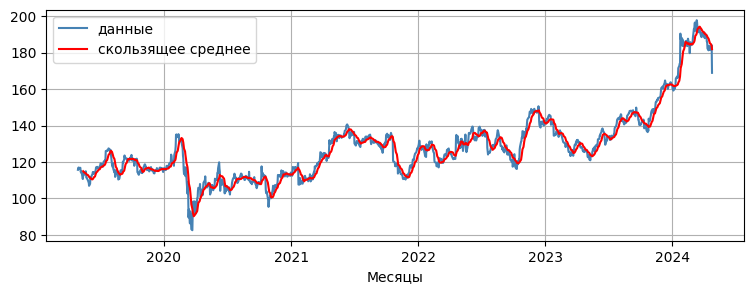

In [5]:
fig,ax = plt.subplots(figsize = (9,3))
ax.plot(df['values'], label = 'данные', color = 'steelblue')
ax.plot(df['values'].rolling(window=12).mean(), label = 'скользящее среднее', color = 'red')
#ax.plot(df['values'].rolling(window=7).mean(), label = 'скользящее среднее', color = 'red')
ax.set_xlabel('Месяцы', )
ax.legend(title = '', loc = 'upper left', )
ax.grid()

__оценка автокорреляции__

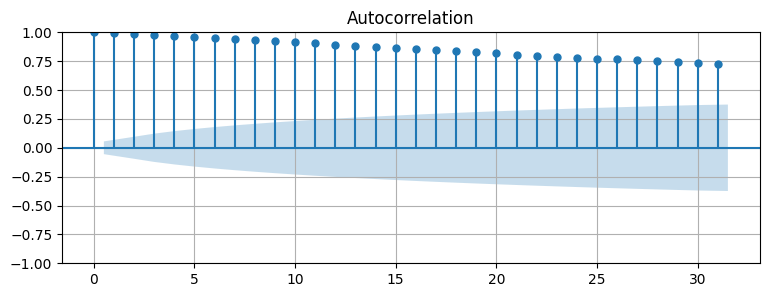

In [6]:
from statsmodels.graphics.tsaplots import plot_acf
fig,ax = plt.subplots(figsize = (9,3))
plot_acf(df['values'],ax=ax)
ax.grid()

# собираем датасет

In [7]:
display( df.index.min(), df.index.max(), )

Timestamp('2019-04-29 00:00:00')

Timestamp('2024-04-25 00:00:00')

In [8]:
# df_train, df_test = df[:'1958-12'],df['1959-01':]
df_train, df_test = df[:'2023-12'],df['2024-01':]

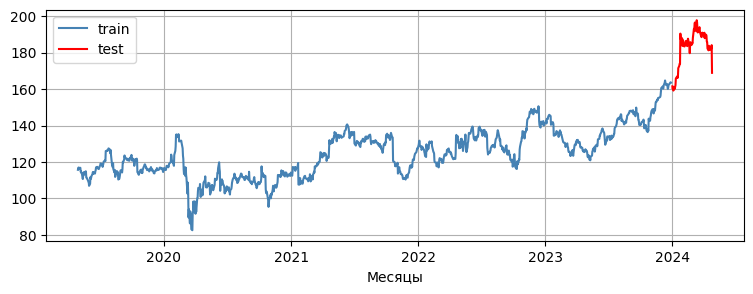

In [9]:
fig,ax = plt.subplots(figsize = (9,3))
ax.plot(df_train['values'], label = 'train', color = 'steelblue')
ax.plot(df_test['values'], label = 'test', color = 'red')
ax.set_xlabel('Месяцы', )
ax.legend(title = '', loc = 'upper left', )
ax.grid()

---

In [10]:
import tsfresh
from tsfresh.utilities import dataframe_functions as F

модель “плавающего окна”,    
для каждого значения формируем  историю предыдущих значений,     
из этой истории строим признаки   

In [11]:
# размер окна, по которому будем строить прогноз
# window_size = 3 # месяцев
window_size = 7 # дней

In [12]:
df_train.loc[:,'id'] = 0 # метка группы
df_train_roll = F.roll_time_series(
        df_train.reset_index(),
        column_id='id', 
        column_sort='date',
        #column_value='values',
        min_timeshift=window_size,
        max_timeshift=window_size, 
        # rolling_direction=1,
        # show_warnings=False,
        disable_progressbar=True,
        n_jobs=4,
    )

# метка группы
df_train_roll.loc[:,'id'] =  pd.to_datetime( df_train_roll['id'].str[1] )

df_train_roll = df_train_roll[ df_train_roll['id']!= df_train_roll['id'].max() ]

display( df_train_roll.head(12))

/tmp/ipykernel_3305759/2930566511.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:,'id'] = 0 # метка группы
/opt/venv/sevgu_1/lib/python3.11/site-packages/tsfresh/utilities/dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(


,date,values,id
0,2019-04-29,115.686,2019-05-08 00:00:00
1,2019-04-30,116.710,2019-05-08 00:00:00
2,2019-05-01,116.955,2019-05-08 00:00:00
3,2019-05-02,116.144,2019-05-08 00:00:00
4,2019-05-03,116.691,2019-05-08 00:00:00
5,2019-05-06,116.798,2019-05-08 00:00:00
6,2019-05-07,114.534,2019-05-08 00:00:00
7,2019-05-08,114.817,2019-05-08 00:00:00
8,2019-04-30,116.710,2019-05-09 00:00:00
9,2019-05-01,116.955,2019-05-09 00:00:00


In [13]:
target_train = df_train.iloc[window_size:]['values'].shift(-1).dropna()
display(target_train)

date
2019-05-08    113.929
2019-05-09    113.920
2019-05-10    110.640
2019-05-13    112.241
2019-05-14    113.148
               ...   
2023-12-21    162.140
2023-12-22    163.210
2023-12-26    163.460
2023-12-27    163.750
2023-12-28    163.550
Name: values, Length: 1170, dtype: float64

In [14]:
%%time 

# df_train_features = tsfresh.extract_features(
#     df_train_roll.reset_index(), 
#     column_id='id', 
#     column_sort='date', 
#     column_value='values',
#     #default_fc_parameters=tsfresh.feature_extraction.MinimalFCParameters()
# )

# df_train_features = tsfresh.extract_features(
#     df_train_roll.reset_index(), 
#     column_id='id', 
#     column_sort='date', 
#     column_value='values',
#     default_fc_parameters=tsfresh.feature_extraction.MinimalFCParameters()
# )


df_train_features = tsfresh.extract_relevant_features(
    df_train_roll.reset_index(), 
    target_train,
    column_id='id',
    column_sort='date',
    column_value='values',
    show_warnings=False,
    disable_progressbar=False,
    n_jobs=4,
)

df_train_features = df_train_features.dropna(axis=1)

feature_settings =  tsfresh.feature_extraction.settings.from_columns(df_train_features)
feature_order = df_train_features.columns

display( len(df_train_features) )
display( df_train_features.sample(3) )
display( list(feature_order) )

Feature Extraction: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.18it/s]


1170

,values__sum_values,"values__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)","values__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)","values__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)","values__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)","values__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)","values__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)","values__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20)","values__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)",values__quantile__q_0.9,...,values__permutation_entropy__dimension_7__tau_1,"values__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.0","values__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.2","values__fft_coefficient__attr_""angle""__coeff_4","values__change_quantiles__f_agg_""mean""__isabs_False__qh_0.6__ql_0.4","values__augmented_dickey_fuller__attr_""teststat""__autolag_""AIC""","values__augmented_dickey_fuller__attr_""pvalue""__autolag_""AIC""",values__fourier_entropy__bins_5,"values__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.8",values__approximate_entropy__m_2__r_0.9
2020-08-11 00:00:00,890.021,149.182171,123.234305,207.538009,173.870334,128.403255,101.250420,201.185264,170.148982,113.4236,...,0.693147,0.171537,0.161835,180.0,0.000,-0.501039,0.891814,0.950271,-0.332,0.016837
2022-03-02 00:00:00,949.005,158.248077,128.701358,218.966006,183.610523,135.624255,104.605246,213.340354,179.151905,119.7848,...,0.693147,0.738136,0.000000,180.0,0.000,-5.522262,0.000002,0.673012,0.000,0.022123
2022-08-03 00:00:00,1016.851,170.164772,141.116467,236.924186,198.390575,146.493434,115.099647,229.508699,194.274776,128.9486,...,0.693147,0.299529,0.515524,180.0,1.533,-0.287545,0.927250,0.950271,0.000,0.325419


['values__sum_values',
 'values__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)',
 'values__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)',
 'values__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)',
 'values__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)',
 'values__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)',
 'values__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)',
 'values__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20)',
 'values__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)',
 'values__quantile__q_0.9',
 'values__quantile__q_0.8',
 'values__quantile__q_0.7',
 'values__quantile__q_0.6',
 'values__quantile__q_0.4',
 'values__quantile__q_0.3',
 'values__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)',
 'values__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20)',
 'values__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20)',
 'values__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20)',
 'values__c

CPU times: user 2.97 s, sys: 243 ms, total: 3.21 s
Wall time: 18.9 s


In [15]:
df_test.loc[:,'id'] = 0 # метка группы
df_test_roll = F.roll_time_series(
        df_test.reset_index(),
        column_id='id', 
        column_sort='date',
        #column_value='values',
        min_timeshift=window_size,
        max_timeshift=window_size, 
        # rolling_direction=1,
        # show_warnings=False,
        disable_progressbar=True,
        n_jobs=4,
    )

df_test_roll = df_test_roll[ df_test_roll['id']!= df_test_roll['id'].max() ]

# метка группы
df_test_roll.loc[:,'id'] =  pd.to_datetime( df_test_roll['id'].str[1] )

# display( df_test_roll.head(12))

df_test_features = tsfresh.extract_features(
        df_test_roll, 
        default_fc_parameters=feature_settings['values'],
        column_id='id', 
        column_sort='date',
        column_value='values',
        disable_progressbar=True,
        impute_function=F.impute, 
        show_warnings=False,
        n_jobs=4,
    )[feature_order]

#display( len(df_test_features) )
#display( df_test_features.sample(3) )

target_test = df_test.iloc[window_size:]['values'].shift(-1).dropna()
#display(target_test)

/tmp/ipykernel_3305759/1874891675.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,'id'] = 0 # метка группы
/opt/venv/sevgu_1/lib/python3.11/site-packages/tsfresh/utilities/dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(


# обучаем модель

In [16]:
from sklearn.preprocessing import PolynomialFeatures

poly =  PolynomialFeatures( 
        degree=1, 
        interaction_only=False, 
        include_bias=True,
    ).fit( df_train_features.values )

x = poly.transform( df_train_features.values  )

predicted_train = target_train.to_frame()
y = np.array(target_train.values,dtype=np.float32)

display( x.shape, y.shape )

(1170, 157)

(1170,)

In [17]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(x,y)

In [18]:
predicted_train['predicted train'] = model.predict(x)
predicted_train = predicted_train.rename(columns={'values':'train data'})

# тестируем

In [19]:
predicted_test = target_test.to_frame()
x = poly.transform( df_test_features.values  )

predicted_test['predicted test'] = model.predict(x)
predicted_test = predicted_test.rename(columns={'values':'test data'})

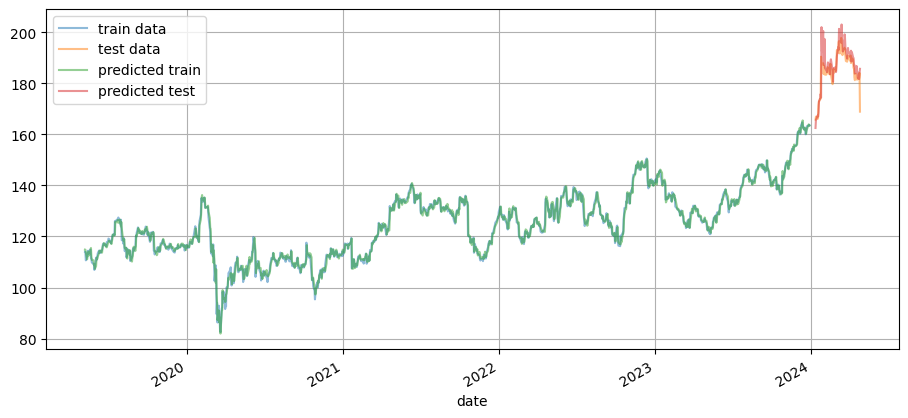

In [20]:
fig,ax = plt.subplots(figsize = (11,5))
predicted_train[['train data']].plot(ax=ax,alpha=.5)
predicted_test[['test data']].plot(ax=ax,alpha=.5)

predicted_train[['predicted train']].plot(ax=ax,alpha=.5,)
predicted_test[['predicted test']].plot(ax=ax,alpha=.5,)

ax.grid()
ax.legend()

In [21]:
from sklearn.metrics import mean_squared_error

display( mean_squared_error( predicted_train['train data'], predicted_train['predicted train']) )
display( mean_squared_error( predicted_test['test data'], predicted_test['predicted test']) )

3.1890425828925952

23.075998858823638